# Voxelization

In [47]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import copy
import os
import IPython.display
import PIL.Image

test_data_dir = "./test_data"

#### Visualization Configurations

In [48]:
# change to True if you want to interact with the visualization windows
interactive = not "CI" in os.environ

def jupyter_draw_geometries(
    geoms,
    window_name="Open3D",
    width=1920,
    height=1080,
    left=50,
    top=50,
    point_show_normal=False,
    mesh_show_wireframe=False,
    mesh_show_back_face=False,
    lookat=None,
    up=None,
    front=None,
    zoom=None,
):
    vis = o3d.visualization.Visualizer()
    vis.create_window(
        window_name=window_name,
        width=width,
        height=height,
        left=left,
        top=top,
        visible=True,  # If false, capture_screen_float_buffer() won't work.
    )
    vis.get_render_option().point_show_normal = point_show_normal
    vis.get_render_option().mesh_show_wireframe = mesh_show_wireframe
    vis.get_render_option().mesh_show_back_face = mesh_show_back_face
    for geom in geoms:
        vis.add_geometry(geom)
    if lookat is not None:
        vis.get_view_control().set_lookat(lookat)
    if up is not None:
        vis.get_view_control().set_up(up)
    if front is not None:
        vis.get_view_control().set_front(front)
    if zoom is not None:
        vis.get_view_control().set_zoom(zoom)
    if interactive:
        vis.run()
    else:
        for geom in geoms:
            vis.update_geometry(geom)
        vis.poll_events()
        vis.update_renderer()
    im = vis.capture_screen_float_buffer()
    vis.destroy_window()
    im = (255 * np.asarray(im)).astype(np.uint8)
    IPython.display.display(PIL.Image.fromarray(im, "RGB"))


o3d.visualization.draw_geometries = jupyter_draw_geometries

## Point Cloud

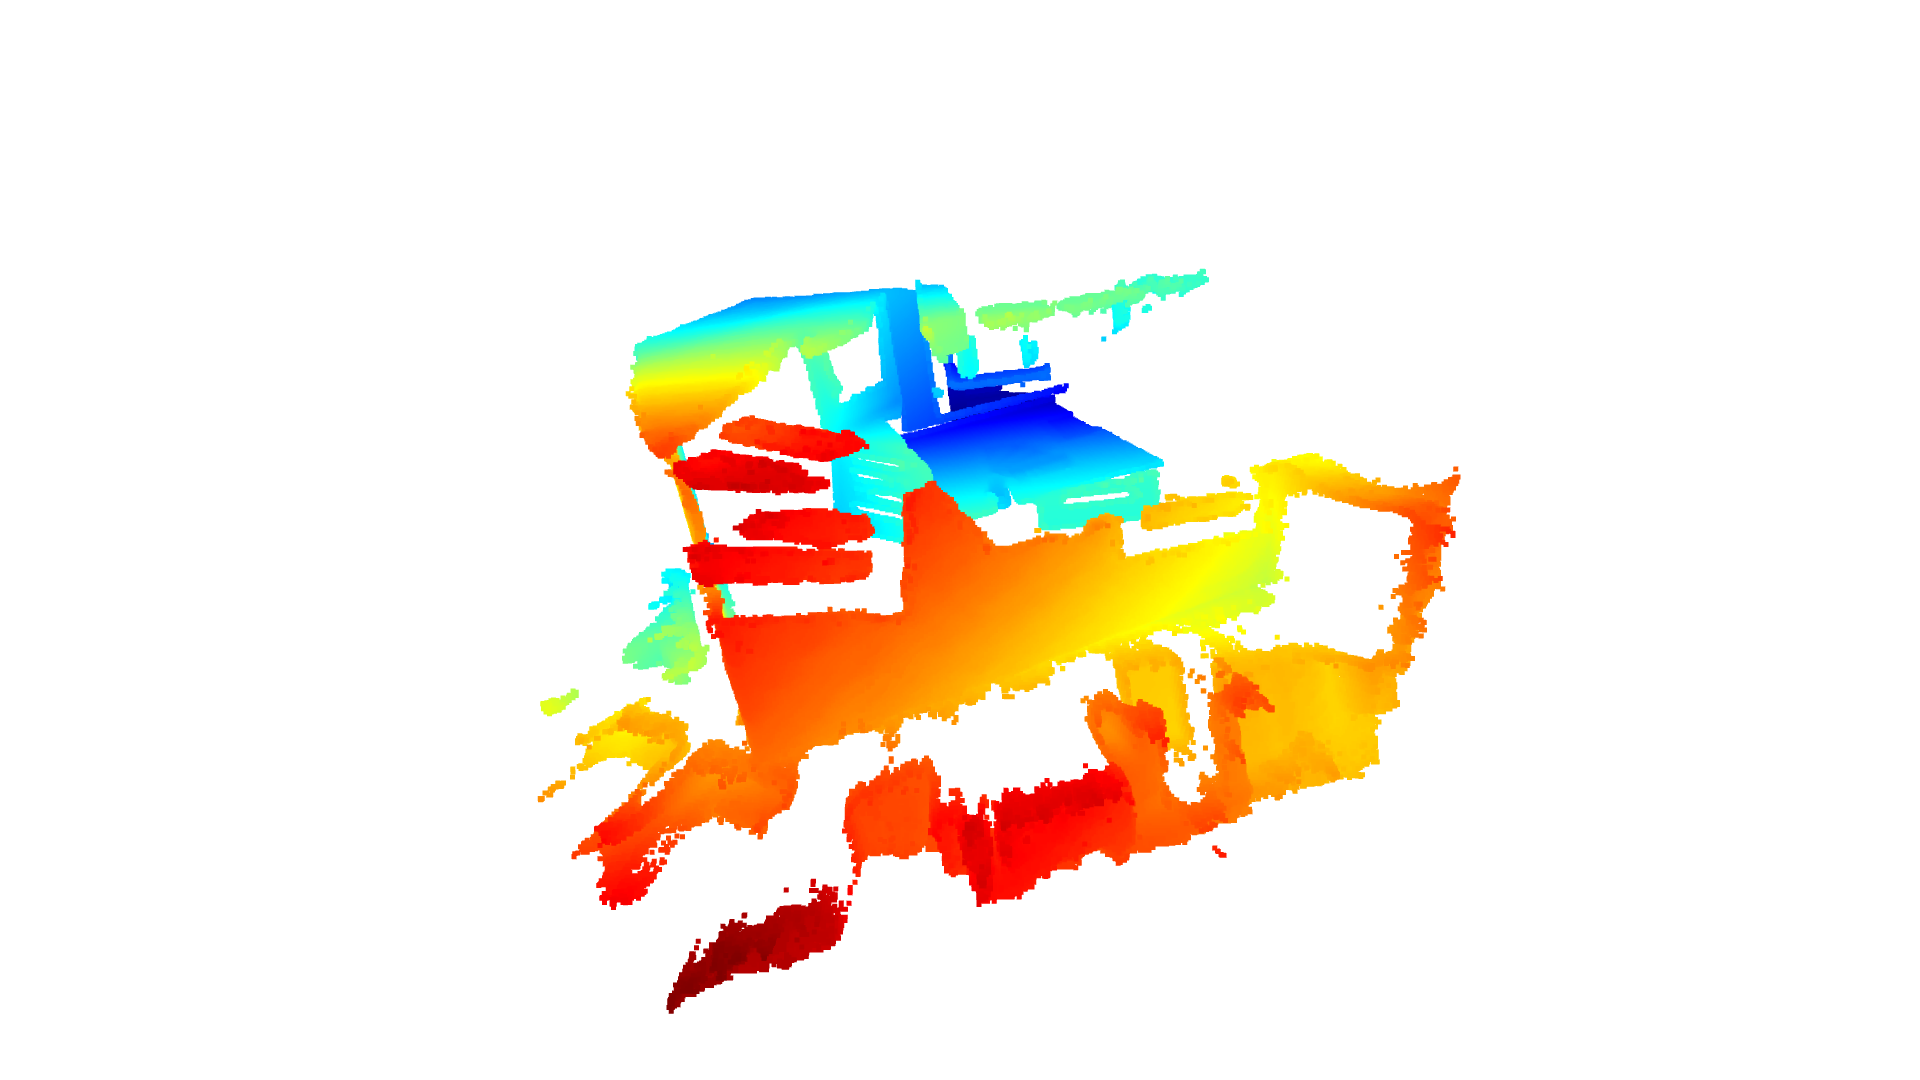

In [49]:
N = 1000
voxel_size = 0.02
pcd_path = test_data_dir + "/cloud_bin_0.ply"
pcd = o3d.io.read_point_cloud(pcd_path)

if not os.path.exists(pcd_path):
    print(f"point cloud not exist in path: {pcd_path}")
else:
    # fit to unit cube
    pcd.scale(1 / np.max(pcd.get_max_bound() - pcd.get_min_bound()),
              center=pcd.get_center())
    pcd.colors = o3d.utility.Vector3dVector(np.random.uniform(0, 1, size=(N, 3)))
    o3d.visualization.draw_geometries([pcd])

#### Downsample

In [93]:
downpcd = pcd.voxel_down_sample(voxel_size=voxel_size)

"""
for point in np.asarray(downpcd.points):
    print(point)

"""

out1, out2, out3 = pcd.voxel_down_sample_and_trace(voxel_size=voxel_size, min_bound=pcd.get_min_bound(), max_bound=pcd.get_max_bound())

"""
print(out1)
print(out2[2])
print(out3[0].pop())
"""

# TEST
pcdarray = np.asarray(pcd.points)
downarray = np.asarray(downpcd.points)

print(len(pcdarray))
print(out1.points[0])
print(pcd.points[out3[0][0]])

#o3d.visualization.draw_geometries([downpcd])


258342
[-0.17409181 -0.71598154  2.7686538 ]
[-0.17409181 -0.71598154  2.7686538 ]


In [81]:
class Cube(object):
    def __init__(self, xrange, yrange, zrange):
        """
        Builds a cube from x, y and z ranges
        """
        self.xrange = xrange
        self.yrange = yrange
        self.zrange = zrange

    @classmethod
    def from_points(cls, firstcorner, secondcorner):
        """
        Builds a cube from the bounding points
        Rectangle.from_points(Point(0, 10, -10),
                              Point(10, 20, 0)) == Rectangle((0, 10), (10, 20), (-10, 0))
        """
        return cls(*zip(firstcorner, secondcorner))

    @classmethod
    def from_voxel_size(cls, center, voxel_size):
        """
        Builds a cube from the voxel size and center of the voxel
        """

        pass
        #return cls(*zip(firstcorner, secondcorner))

    # TODO: Change Point type with ndarray
    def contains_point(self, p):
        """
        Return given point is in cube
        """
        if not all(hasattr(p, loc) for loc in 'xyz'):
            raise TypeError("Can only check 3D points.")
        return all([self.xrange[0] <= p.x <= self.xrange[1],
                    self.yrange[0] <= p.y <= self.yrange[1],
                    self.zrange[0] <= p.z <= self.zrange[1]])

# TODO: Change Point type with ndarray 
# Temp class for test reasons
class Point(object):
    """
    Builds a point in 3D
    """
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

    def __iter__(self): 
        yield from (self.x, self.y, self.z)

cube = Cube((0, 10), (10, 20), (-10, 0)) # Bounding points: (0, 10, -10), (10, 20, 0)
inside_point = Point(3, 15, -8)
outside_point = Point(11, 15, -8)

print(cube.contains_point(inside_point)) # True
cube.contains_point(outside_point)  # False

True


False

#### Voxelization

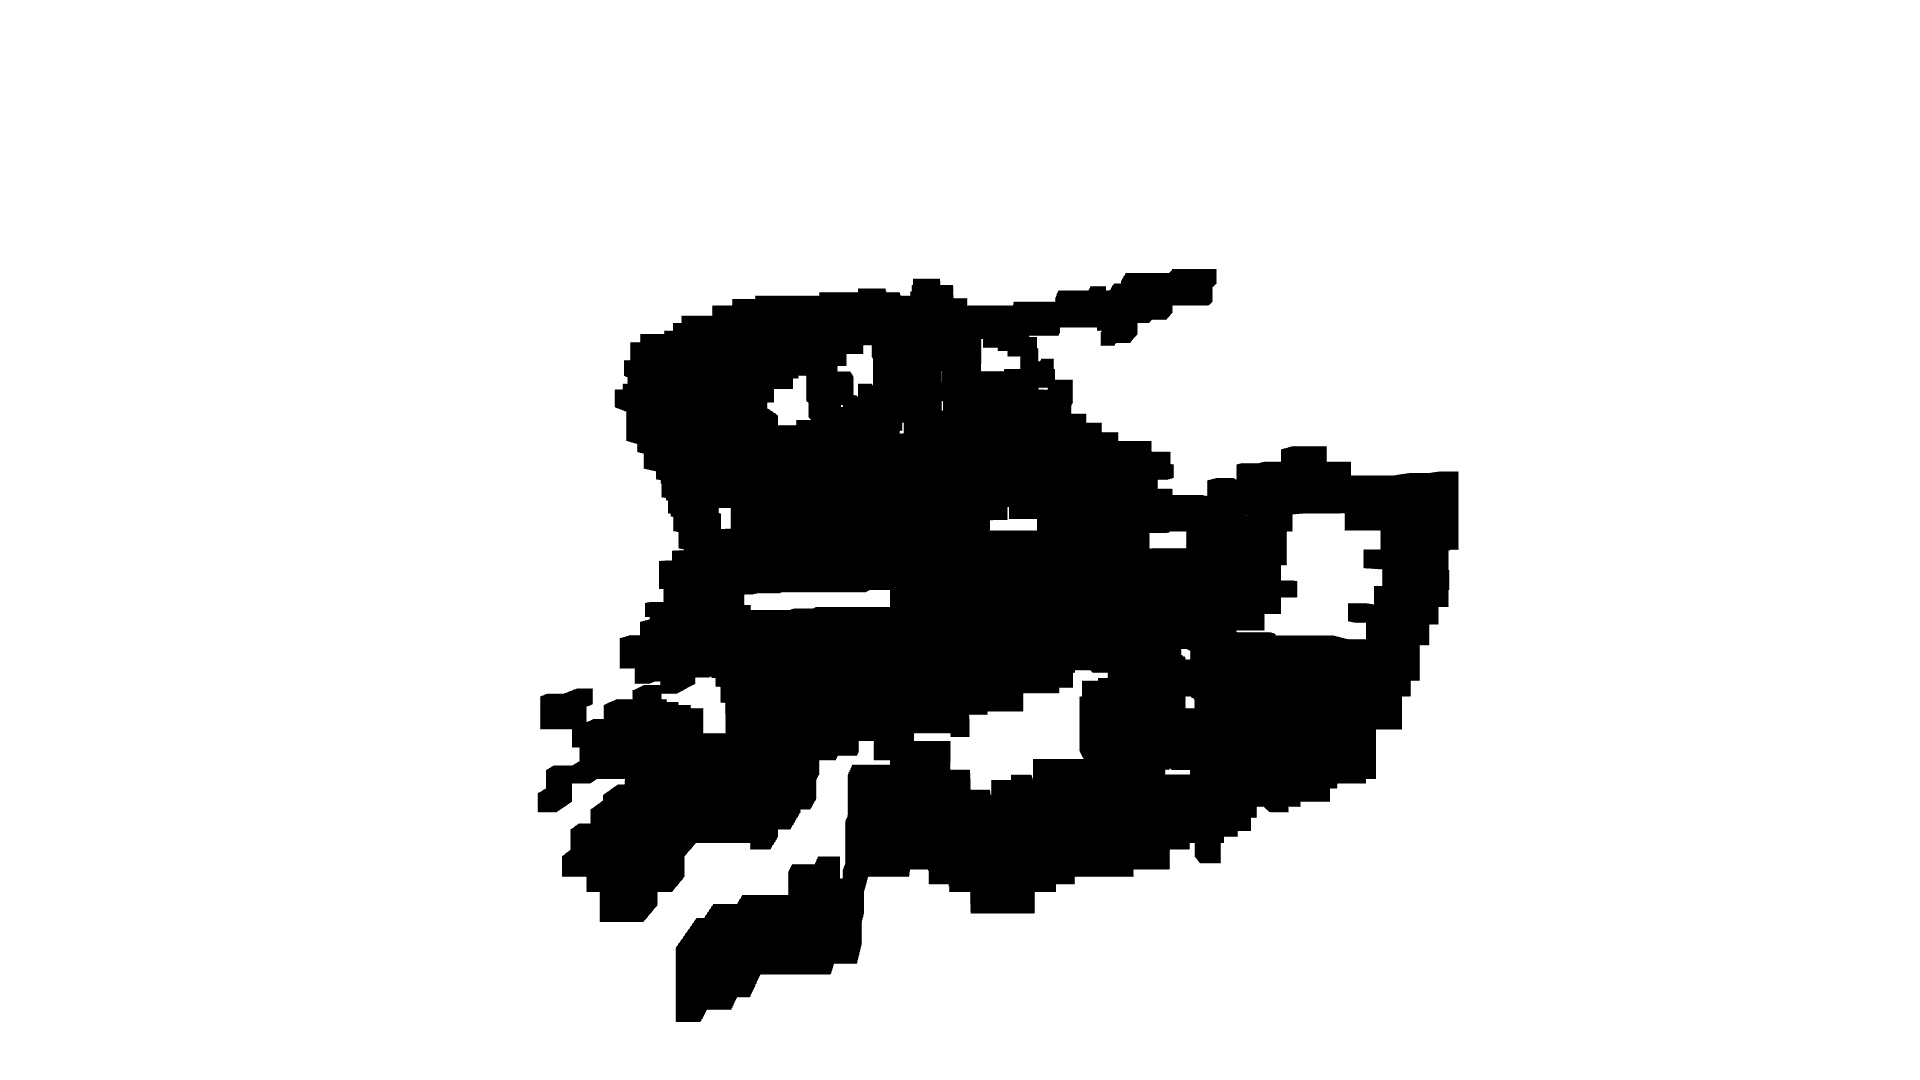

In [72]:
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd,
                                                            voxel_size=voxel_size)
#print(voxel_grid.get_voxel(np.ndarray(shape=(3,1), dtype=float, order='F')))
o3d.visualization.draw_geometries([voxel_grid])

## Mesh

In [6]:
"""
mesh_path = f"{test_data_dir}/cloud_bin_0_mesh.ply"
if not os.path.exists(mesh_path):
    print(f"mesh not exist in path{mesh_path}")
    quit()

mesh = o3d.io.read_triangle_mesh(mesh_path)
mesh.compute_vertex_normals()
# fit to unit cube
mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()),
           center=mesh.get_center())
o3d.visualization.draw_geometries([mesh])
"""

[Open3D WARNING] Read PLY failed: unable to open file: ./cloud_bin_0_mesh.ply


RuntimeError: [1;31m[Open3D ERROR] [CreateCoordinateFrame] size &lt;= 0[0;m

#### Voxelization

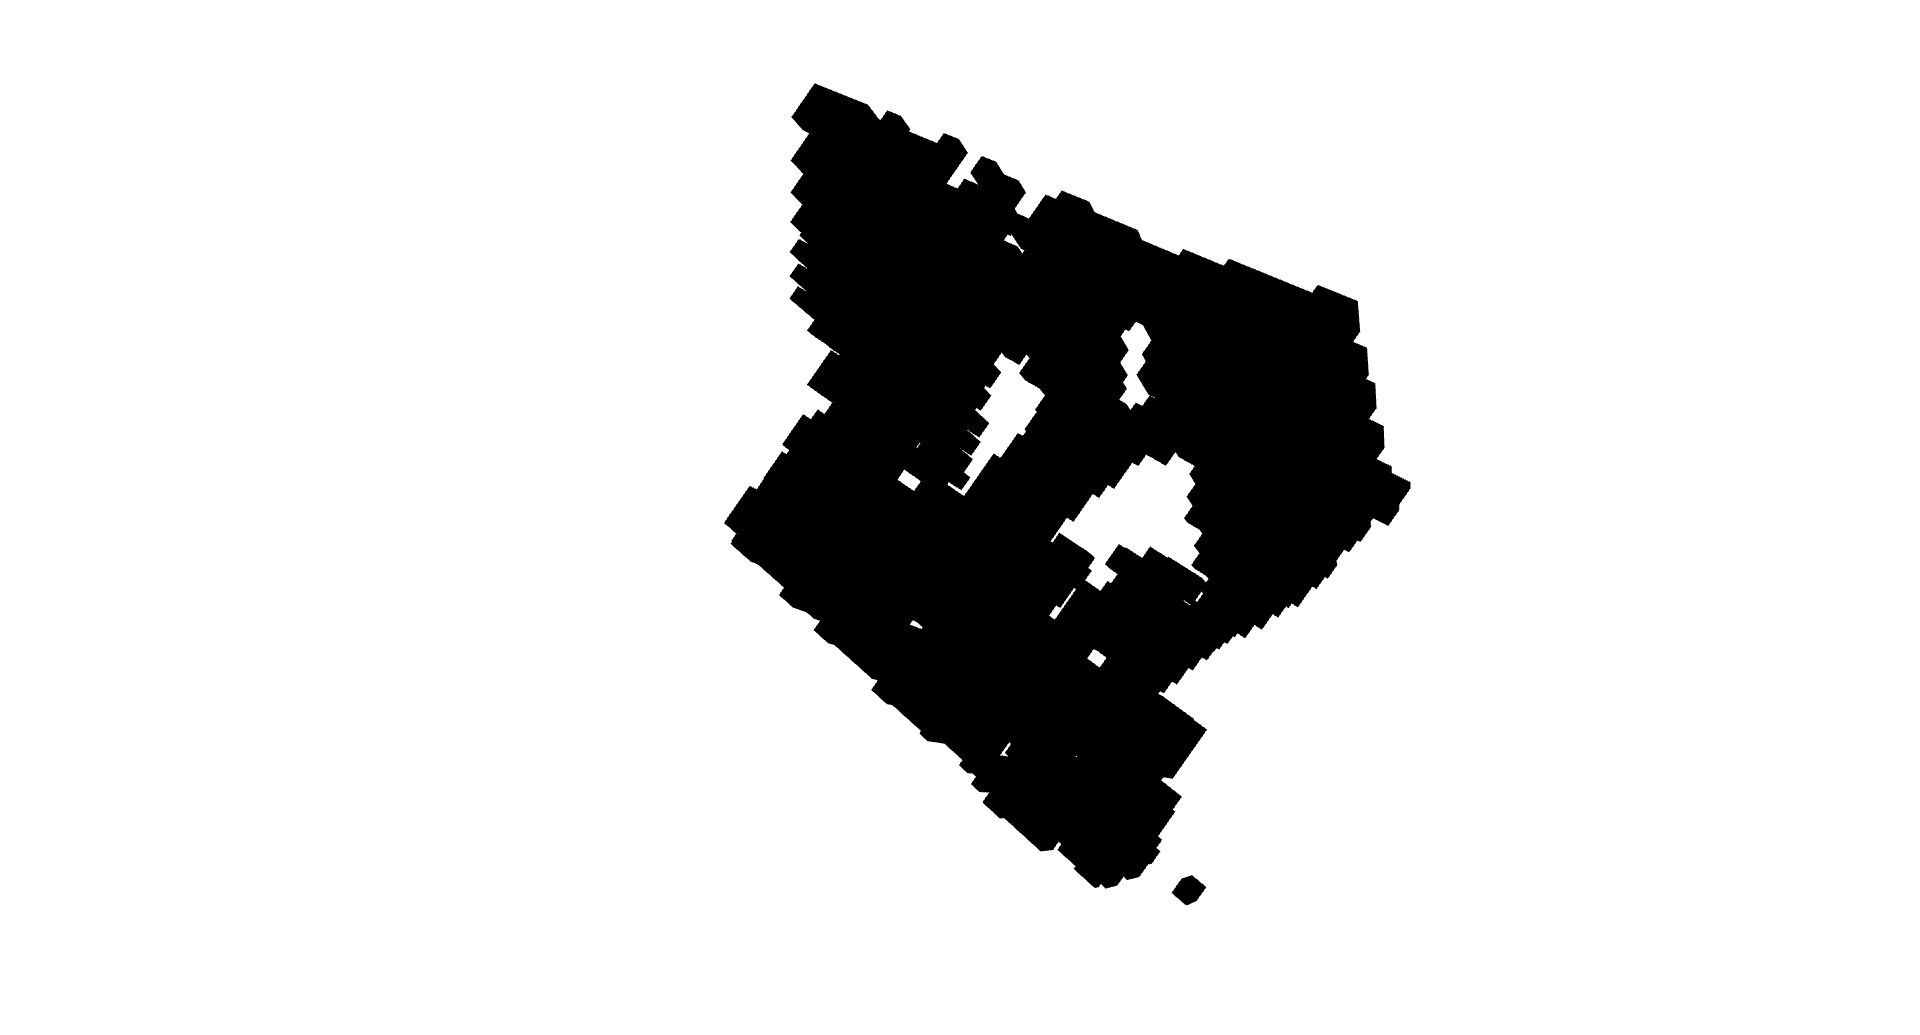

In [11]:
"""
voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh,
                                                              voxel_size=voxel_s)
o3d.visualization.draw_geometries([voxel_grid])
"""